In [1]:
import numpy as np

# Loading the dataset
dataset = np.load('qm7x_eq.npz', allow_pickle=True)

# What is inside?
for f in dataset.files:
    print(f)

EAT
S
xyz
Z


In [2]:
# Importing data
EAT = dataset['EAT'] # atomization energy
xyz = dataset['xyz'] # Cartesian coordinates
Z = dataset['Z'] # atomic indexes

n_molecules = len(xyz)
print('The number of molecules in the dataset is {:d}.'.format(n_molecules))

The number of molecules in the dataset is 41537.


In [3]:
from tqdm import tqdm
from scipy.spatial.distance import pdist

# Descriptor
def descriptor(R):
    
    nconfig = len(R)
    D = []
    for i in tqdm(range(nconfig)):
        D.append(1./pdist(R[i]))
    
    return D

d = descriptor(xyz)

# Making all descriptor entries of the same size
max_size = np.max([len(_) for _ in d])
nconfig = len(d)
D = np.zeros((nconfig, max_size))

for i in range(nconfig):
    size = len(d[i])
    D[i, :size] = d[i]

100%|██████████| 41537/41537 [00:00<00:00, 72287.08it/s]


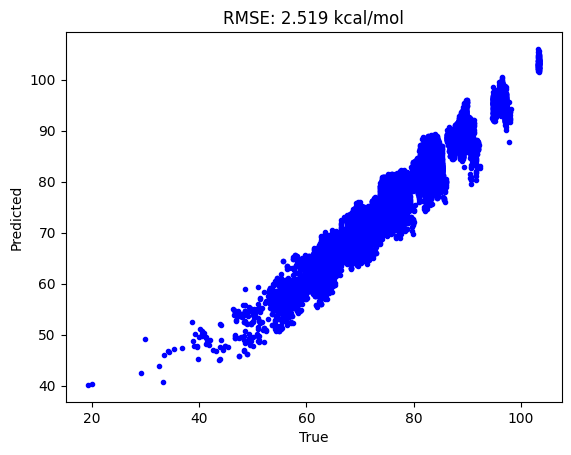

In [4]:
from sklearn import linear_model
import matplotlib.pyplot as plt

# ridge regression
reg = linear_model.Ridge(alpha=1e-8)
reg.fit(D, EAT)

rmse = np.sqrt(np.square(EAT - reg.predict(D)).mean())
plt.title('RMSE: {:.3f} kcal/mol'.format(rmse))
plt.scatter(EAT, reg.predict(D), marker='.', color='blue')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

100%|██████████| 41537/41537 [00:13<00:00, 3056.85it/s]


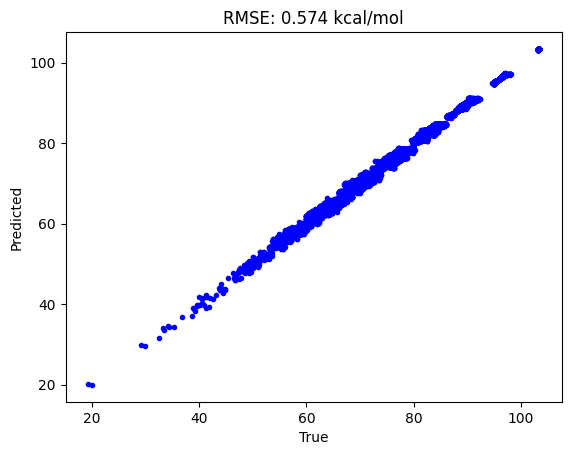

In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import pdist
from sklearn import linear_model
import matplotlib.pyplot as plt

dataset = np.load('qm7x_eq.npz', allow_pickle=True)

EAT = dataset['EAT'] # atomization energy
xyz = dataset['xyz'] # Cartesian coordinates
Z = dataset['Z'] # atomic indexes

def descriptor(R):
    uniqueZ = np.sort(np.unique(np.concatenate(Z))).astype(int)
    pairs = [(a, b) for idx, a in enumerate(uniqueZ) for b in uniqueZ[idx:]]
    nconfig = len(R)
    D = []
    for i in tqdm(range(nconfig)):
        Zi = Z[i].astype(float)
        n = len(Zi)
        dists = pdist(R[i])
        # Z_i * Z_j / r_ij
        charges = np.array([Zi[a] * Zi[b] for a in range(n-1) for b in range(a+1, n)])
        Rinv = charges / dists
        keys = np.array([[min(int(Zi[a]), int(Zi[b])), max(int(Zi[a]), int(Zi[b]))]
                         for a in range(n-1) for b in range(a+1, n)])
        parts = []
        for (a, b) in pairs:
            mask = (keys[:, 0] == a) & (keys[:, 1] == b)
            if np.any(mask):
                parts.append(np.sort(Rinv[mask]))
        # CM diagonal: 0.5 * Z^2.4
        diagonal = np.sort(0.5 * Zi ** 2.4)[::-1]
        counts = np.array([(Zi == z).sum() for z in uniqueZ])
        D.append(np.concatenate((counts, diagonal, np.concatenate(parts))))
    return D

d = descriptor(xyz)

max_size = np.max([len(_) for _ in d])
nconfig = len(d)
D = np.zeros((nconfig, max_size))

for i in range(nconfig):
    size = len(d[i])
    D[i, :size] = d[i]
    

# ridge regression
reg = linear_model.Ridge(alpha=1e-8)
reg.fit(D, EAT)

rmse = np.sqrt(np.square(EAT - reg.predict(D)).mean())
plt.title('RMSE: {:.3f} kcal/mol'.format(rmse))
plt.scatter(EAT, reg.predict(D), marker='.', color='blue')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()